In [1]:
#importing necessary libraries
import random
import numpy as np
import pandas as pd
import cv2
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import image as img
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from keras.applications import resnet, inception_v3
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# <span style=color:black> Load and View Data

In [2]:
def load_data(csv_file):
    """
    This function converts the data from a csv file into a dataframe format and returns the dataframe
        Parameters
        ----------
        csv_file : str
            The file path of a csv file
        Returns
        -------
        dataframe
    """
    df = pd.read_csv(csv_file)
    return df

In [3]:
def four_random_images(file_path,title_col):
    """
    This function displays four random images
    Parameters
        ----------
        file_path : str
            The file path to the image
        title_col: str
            The column to look through
        Returns
        -------
        random images
    """
    plt.figure(figsize=(20,20))
    for i in range(4):
        r_int = random.randint(0,len(df_activities)-1)
        fp = file_path[r_int]
        if os.path.exists(fp):
            plt.subplot(4//2+1, 2, i + 1)
            image = img.imread(fp)
            plt.imshow(image)
            plt.title(df_activities[title_col][r_int])

In [4]:
csv_file='./data/csv_file.csv'
df_activities = load_data(csv_file)
df_activities.head(2)

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop


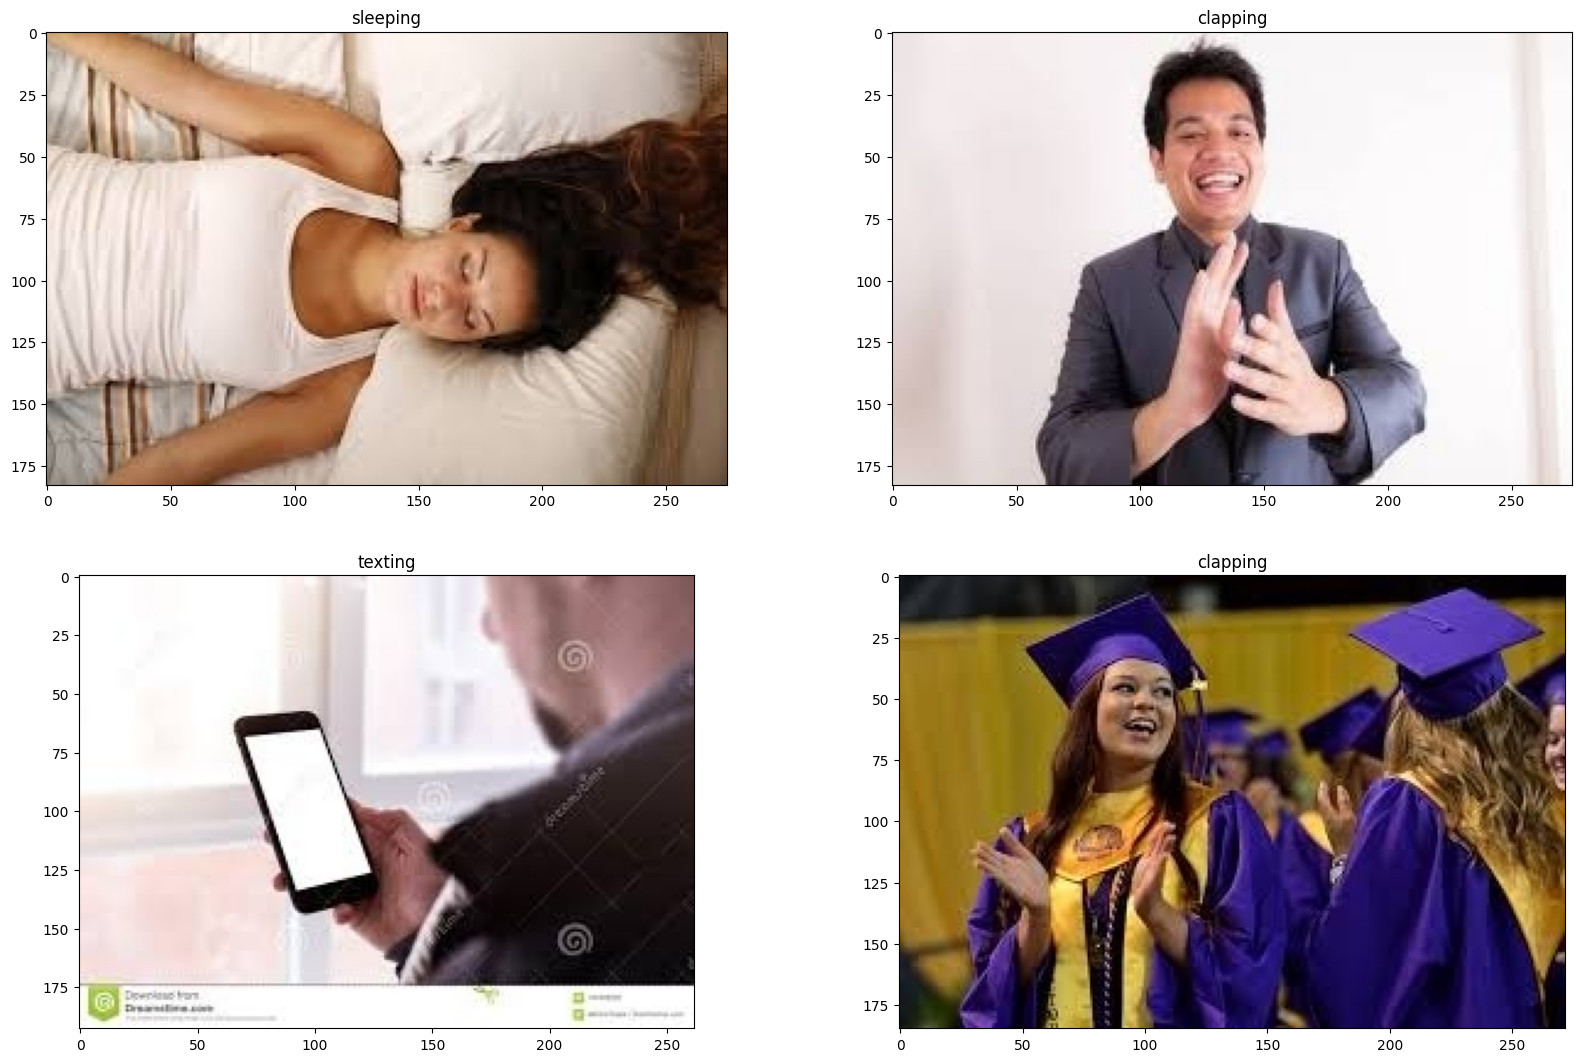

In [5]:
 fp = './data/images/' + df_activities['filename']
four_random_images(fp,'label')

# <span style=color:black> Preprocessing

In [6]:
def encode_categories(col):
    """
    This function accepts a column with categorical data and encodes it as digits
    Parameters
        ----------
        col : list
            The column to be encoded
        -------
        returns two lists
    """
    labels= col.unique()
    return labels, col.apply(lambda x: list(labels).index(x)) 

In [7]:
def data_to_lists(filepath,df,X_col,y_col):
    """
    This function stores images and labels into lists and returns the lists
    Parameters
        ----------
        filepath : str
            The filepath of the images
        df : pandas Dataframe
            The dataframe containing the names of the images and their labels
        X_col : str
            The column name of the image names
        y_col : str
            The column name of the labels
        -------
        returns two lists
    """
    X, y = [], []

    for i in range(len(df)):
        image =filepath+df[X_col][i]
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(df[y_col][i])
    return X,y

In [8]:
def scale_image(image_set):
    return image_set/255

In [9]:
df_activities['label'].value_counts()

sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64

In [10]:
labels = encode_categories(df_activities["label"])[0]
df_activities["label"] = encode_categories(df_activities["label"])[1]
num_classes=len(df_activities["label"].unique())
filepath="./data/images/"
result = data_to_lists(filepath,df_activities,'filename','label')
X = np.array(result[0])
y = np.array(result[1])

In [11]:
print(labels)

['sitting' 'using_laptop' 'hugging' 'sleeping' 'drinking' 'clapping'
 'dancing' 'cycling' 'calling' 'laughing' 'eating' 'fighting'
 'listening_to_music' 'running' 'texting']


In [12]:
#Split into test-train
X_train, X_test, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.1)

#scaling the data
X_train_scaled = scale_image(X_train)
X_test_scaled = scale_image(X_test)

# <span style=color:black> Building the Models
> I would first build a CNN model from scratch

In [ ]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [13]:
#Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(224, 
                                                              224,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [14]:
def plot_acc_loss(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [15]:
def Cnn_model():
    model = Sequential([
        data_augmentation,
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [16]:
def DenseNet201():
    pretrained_model = Sequential([
    data_augmentation,
    tf.keras.applications.DenseNet201(input_shape=(224,224,3),weights='imagenet', include_top=False)
    ], name='pretrained_model')
    pretrained_model.trainable=False
    model = Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(units=15,activation='softmax')], name='custom_densenet_model')
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [17]:
def VGGModel():
    model = Sequential()
    pretrained_model= tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3),pooling='avg',classes=15,weights='imagenet')
    for i in range(len(pretrained_model.layers)):
        pretrained_model.layers[i].trainable=False
    model.add(pretrained_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(15, activation='softmax'))
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [18]:
def InceptionV3():
    model = Sequential()
    model.add(inception_v3.InceptionV3(include_top=False, pooling='max', weights='imagenet', input_shape=(224, 224, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Dense(15, activation='softmax'))
    model.layers[0].trainable = False
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [19]:
def recompile(model,optimize,metrics):
    model.compile(optimizer=optimize, loss='categorical_crossentropy',metrics=metrics)
    return model

### CNN Model

In [20]:
early = EarlyStopping(monitor="val_loss",patience=3)
lr_reduction= ReduceLROnPlateau(monitor="val_loss",patience=2,verbose=1,factor=0.3,min_lr=0.000001)
cnn_modelcheck= ModelCheckpoint('best_cnn.hdf5',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
dense_modelcheck= ModelCheckpoint('best_dense.hdf5',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
inception_modelcheck= ModelCheckpoint('best_inception.hdf5',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
vgg_modelcheck= ModelCheckpoint('best_vgg.hdf5',monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

In [21]:
cnn_model = Cnn_model()

In [22]:
cnn_history= cnn_model.fit(X_train_scaled,y_train_1,epochs=30,validation_data=(X_test_scaled,y_test_1),callbacks=[early,lr_reduction,cnn_modelcheck],verbose=1)

Epoch 1/30
355/355 [==============================] - ETA: 0s - loss: 2.6210 - accuracy: 0.1315
Epoch 1: val_accuracy improved from -inf to 0.20794, saving model to best_cnn.hdf5
355/355 [==============================] - 18s 32ms/step - loss: 2.6210 - accuracy: 0.1315 - val_loss: 2.4585 - val_accuracy: 0.2079 - lr: 1.0000e-04
Epoch 2/30
353/355 [============================>.] - ETA: 0s - loss: 2.4215 - accuracy: 0.2057
Epoch 2: val_accuracy improved from 0.20794 to 0.22857, saving model to best_cnn.hdf5
355/355 [==============================] - 9s 25ms/step - loss: 2.4211 - accuracy: 0.2058 - val_loss: 2.3678 - val_accuracy: 0.2286 - lr: 1.0000e-04
Epoch 3/30
354/355 [============================>.] - ETA: 0s - loss: 2.3240 - accuracy: 0.2428
Epoch 3: val_accuracy improved from 0.22857 to 0.24921, saving model to best_cnn.hdf5
355/355 [==============================] - 9s 25ms/step - loss: 2.3241 - accuracy: 0.2428 - val_loss: 2.2766 - val_accuracy: 0.2492 - lr: 1.0000e-04
Epoch 4/3

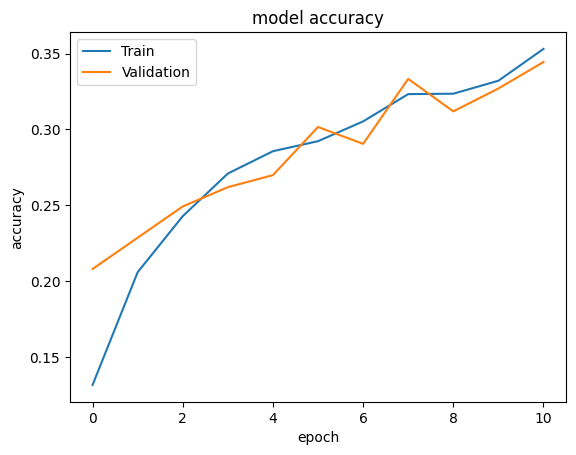

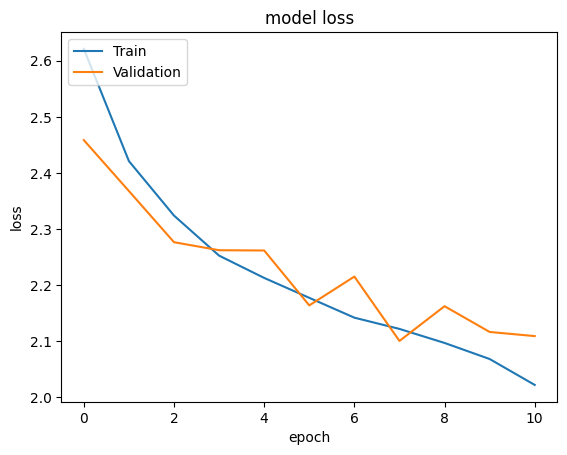

In [23]:
plot_acc_loss(cnn_history)

In [24]:
cnn_model.evaluate(X_test_scaled,y_test_1)

40/40 [==============================] - 0s 7ms/step - loss: 2.1093 - accuracy: 0.3444


[2.1093292236328125, 0.3444444537162781]

In [25]:
#Deleted these variables to free up memory space since model has been saved
del cnn_model
del cnn_history

### Transfer Learning Models
1. DenseNet
2. VGG
3. Inception V5

In [26]:
dense201_model = DenseNet201()
vgg_model = VGGModel()
inceptionv3_model=InceptionV3()

In [27]:
y = to_categorical(np.asarray(df_activities['label'].factorize()[0]))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train_scaled = scale_image(X_train)
X_test_scaled = scale_image(X_test)

In [28]:
dense_history= dense201_model.fit(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test),callbacks=[early,lr_reduction,dense_modelcheck],verbose=1)

Epoch 1/20
355/355 [==============================] - ETA: 0s - loss: 2.6305 - accuracy: 0.1542
Epoch 1: val_accuracy improved from -inf to 0.30238, saving model to best_dense.hdf5
355/355 [==============================] - 35s 80ms/step - loss: 2.6305 - accuracy: 0.1542 - val_loss: 2.2134 - val_accuracy: 0.3024 - lr: 1.0000e-04
Epoch 2/20
354/355 [============================>.] - ETA: 0s - loss: 2.1342 - accuracy: 0.3148
Epoch 2: val_accuracy improved from 0.30238 to 0.41905, saving model to best_dense.hdf5
355/355 [==============================] - 24s 68ms/step - loss: 2.1340 - accuracy: 0.3150 - val_loss: 1.8744 - val_accuracy: 0.4190 - lr: 1.0000e-04
Epoch 3/20
354/355 [============================>.] - ETA: 0s - loss: 1.9056 - accuracy: 0.3904
Epoch 3: val_accuracy improved from 0.41905 to 0.46984, saving model to best_dense.hdf5
355/355 [==============================] - 24s 68ms/step - loss: 1.9060 - accuracy: 0.3901 - val_loss: 1.6867 - val_accuracy: 0.4698 - lr: 1.0000e-04
E

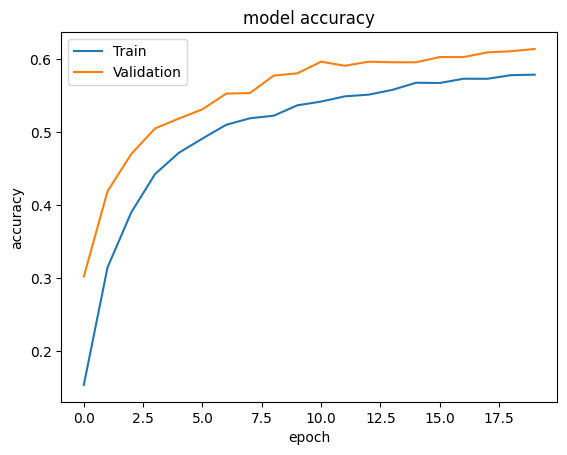

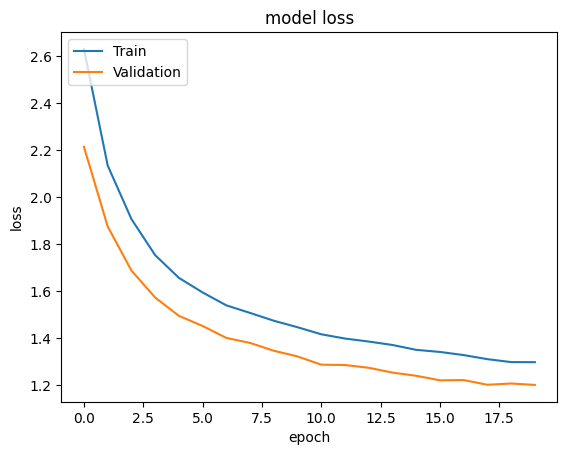

In [29]:
plot_acc_loss(dense_history)

In [30]:
#Deleting to free memory space
del dense201_model
del dense_history

In [31]:
#VGG

In [32]:
vgg_hist= vgg_model.fit(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test),callbacks=[early,lr_reduction,vgg_modelcheck],verbose=1)

Epoch 1/20
355/355 [==============================] - ETA: 0s - loss: 2.5027 - accuracy: 0.2582
Epoch 1: val_accuracy improved from -inf to 0.35952, saving model to best_vgg.hdf5
355/355 [==============================] - 21s 54ms/step - loss: 2.5027 - accuracy: 0.2582 - val_loss: 2.3145 - val_accuracy: 0.3595 - lr: 1.0000e-04
Epoch 2/20
354/355 [============================>.] - ETA: 0s - loss: 2.1266 - accuracy: 0.3882
Epoch 2: val_accuracy improved from 0.35952 to 0.40873, saving model to best_vgg.hdf5
355/355 [==============================] - 16s 45ms/step - loss: 2.1262 - accuracy: 0.3884 - val_loss: 2.0317 - val_accuracy: 0.4087 - lr: 1.0000e-04
Epoch 3/20
355/355 [==============================] - ETA: 0s - loss: 1.9075 - accuracy: 0.4333
Epoch 3: val_accuracy improved from 0.40873 to 0.43095, saving model to best_vgg.hdf5
355/355 [==============================] - 16s 45ms/step - loss: 1.9075 - accuracy: 0.4333 - val_loss: 1.8864 - val_accuracy: 0.4310 - lr: 1.0000e-04
Epoch 4

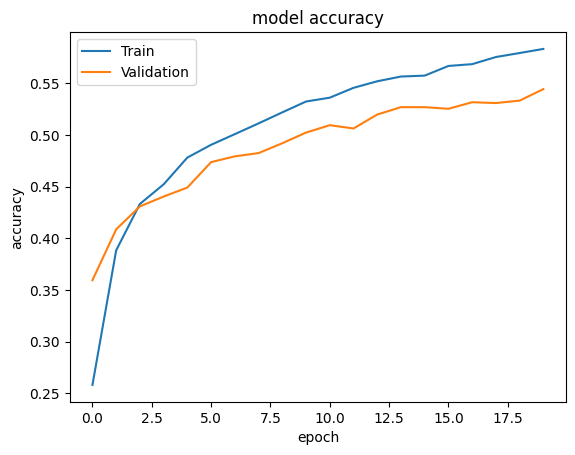

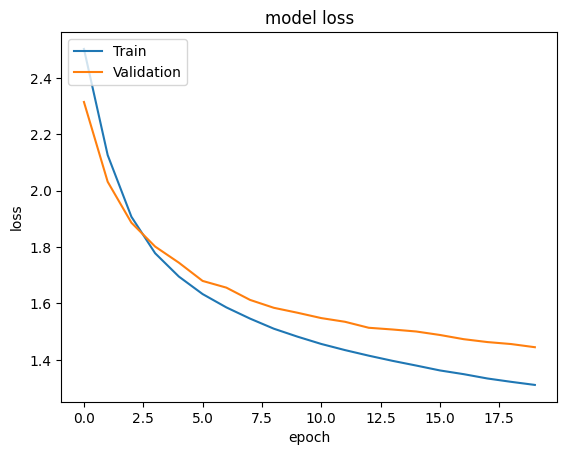

In [33]:
plot_acc_loss(vgg_hist)

In [34]:
#Deleting to free memory space
del vgg_model
del vgg_hist

In [35]:
inceptionv3_hist= inceptionv3_model.fit(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test),callbacks=[early,lr_reduction,inception_modelcheck],verbose=1)

Epoch 1/20
355/355 [==============================] - ETA: 0s - loss: 2.7131 - accuracy: 0.2453
Epoch 1: val_accuracy improved from -inf to 0.43254, saving model to best_inception.hdf5
355/355 [==============================] - 17s 36ms/step - loss: 2.7131 - accuracy: 0.2453 - val_loss: 1.8619 - val_accuracy: 0.4325 - lr: 1.0000e-04
Epoch 2/20
354/355 [============================>.] - ETA: 0s - loss: 1.8693 - accuracy: 0.4331
Epoch 2: val_accuracy improved from 0.43254 to 0.49524, saving model to best_inception.hdf5
355/355 [==============================] - 10s 27ms/step - loss: 1.8685 - accuracy: 0.4333 - val_loss: 1.6301 - val_accuracy: 0.4952 - lr: 1.0000e-04
Epoch 3/20
352/355 [============================>.] - ETA: 0s - loss: 1.6440 - accuracy: 0.5020
Epoch 3: val_accuracy improved from 0.49524 to 0.52222, saving model to best_inception.hdf5
355/355 [==============================] - 9s 27ms/step - loss: 1.6438 - accuracy: 0.5016 - val_loss: 1.5368 - val_accuracy: 0.5222 - lr: 1

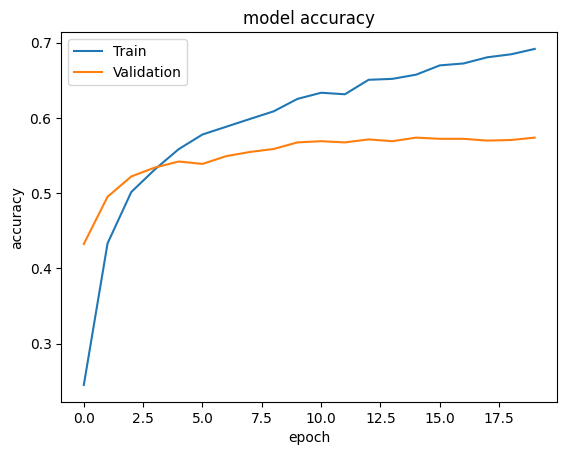

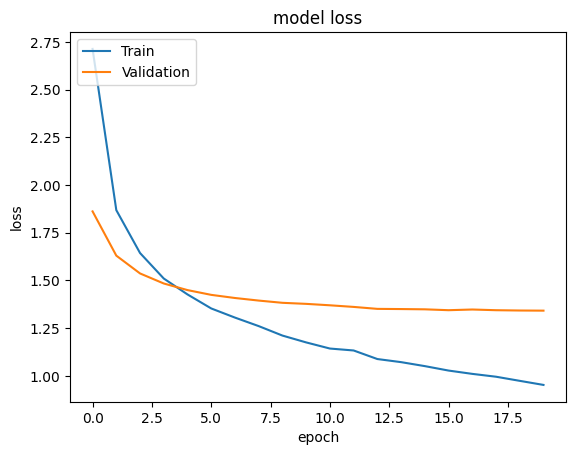

In [36]:
plot_acc_loss(inceptionv3_hist)

### Evaluating the models

In [37]:
def plot_cm(actual,predicted,labels):
    cm = confusion_matrix(actual,predicted)
    fig = plt.figure(figsize=(11,7))
    ax = fig.add_subplot(111)
    sns.heatmap(cm,annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    labels = labels
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    deg = {"rotation" : 90}
    deg2 = {"rotation" : 0}
    plt.setp(ax.get_xticklabels(), **deg)
    plt.setp(ax.get_yticklabels(), **deg2)

In [38]:
from keras.models import load_model
loaded_dense = load_model('best_dense.hdf5')
loaded_inception = load_model('best_inception.hdf5')
loaded_vgg = load_model('best_vgg.hdf5')
loaded_cnn = load_model('best_cnn.hdf5')

In [39]:
evaluate_cnn = loaded_cnn.evaluate(X_test_scaled,y_test_1)

40/40 [==============================] - 0s 7ms/step - loss: 3.7383 - accuracy: 0.0746


In [40]:
y_test_list = list(y_test)
actual_values= [list(x).index(1) for x in y_test_list]

In [41]:
evaluate_vgg = loaded_vgg.evaluate(X_test_scaled,y_test)

40/40 [==============================] - 2s 39ms/step - loss: 1.4449 - accuracy: 0.5444


40/40 [==============================] - 2s 39ms/step


Text(0.5, 1.0, 'Confusion Matrix for the VGG Model')

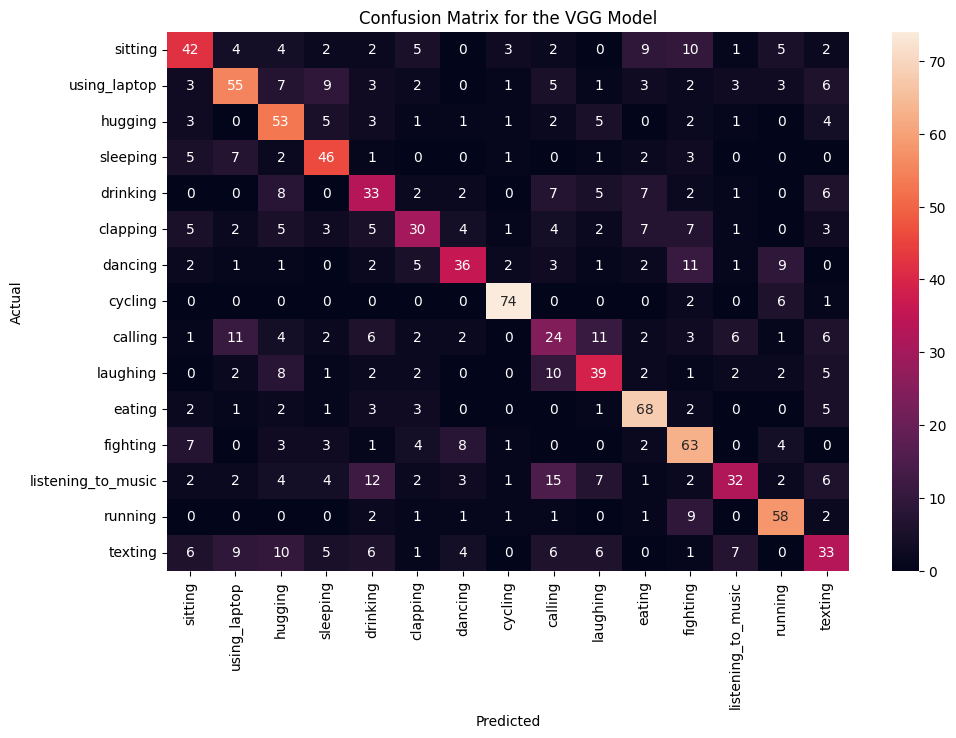

In [42]:
vgg_predictions= loaded_vgg.predict(X_test_scaled)
vgg_predictions = np.array(vgg_predictions)
vgg_predictions_list = [np.argmax(i) for i in vgg_predictions]
plot_cm(actual_values,vgg_predictions_list,labels)
plt.title('Confusion Matrix for the VGG Model')

In [43]:
evaluate_dense = loaded_dense.evaluate(X_test_scaled,y_test)

40/40 [==============================] - 4s 51ms/step - loss: 1.1995 - accuracy: 0.6135


40/40 [==============================] - 3s 47ms/step


Text(0.5, 1.0, 'Confusion Matrix for the Densenet 201 Model')

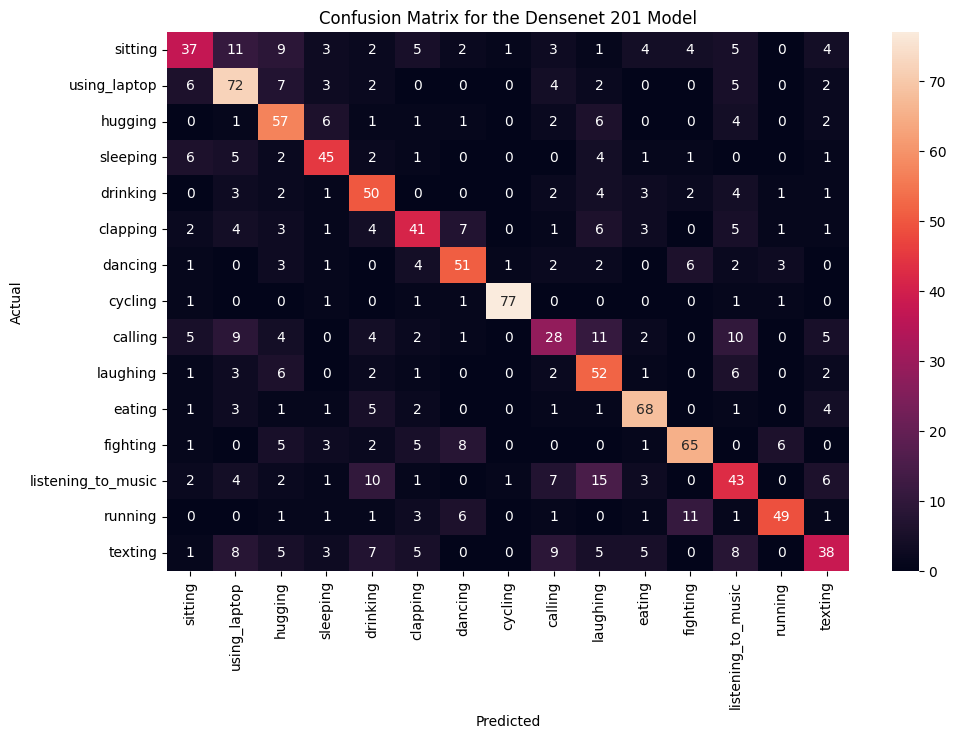

In [44]:
dense_predictions= loaded_dense.predict(X_test_scaled)
dense_predictions = np.array(dense_predictions)
dense_predictions_list = [np.argmax(i) for i in dense_predictions]
plot_cm(actual_values,dense_predictions_list,labels)
plt.title('Confusion Matrix for the Densenet 201 Model')

In [45]:
evaluate_inception =loaded_inception.evaluate(X_test_scaled,y_test)

40/40 [==============================] - 1s 23ms/step - loss: 1.3488 - accuracy: 0.5738


40/40 [==============================] - 1s 21ms/step


Text(0.5, 1.0, 'Confusion Matrix for the Inception V3 Model')

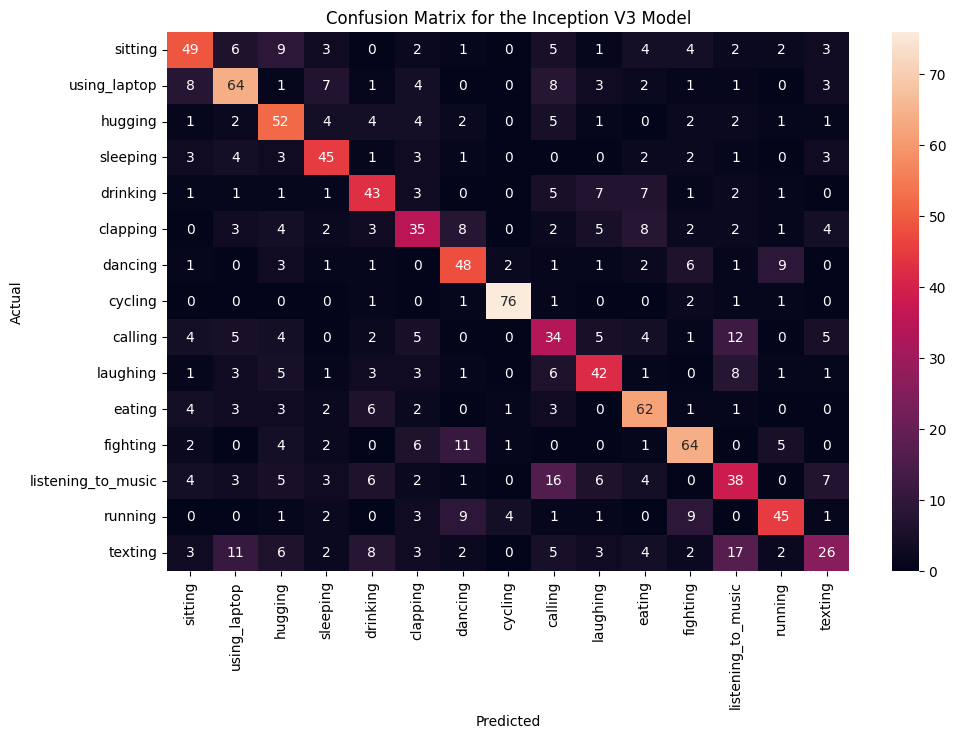

In [46]:
inception_predictions= loaded_inception.predict(X_test_scaled)
inception_predictions = np.array(inception_predictions)
inception_predictions_list = [np.argmax(i) for i in inception_predictions]
plot_cm(actual_values,inception_predictions_list,labels)
plt.title('Confusion Matrix for the Inception V3 Model')

In [47]:
performaces = {'Model': ['MyCNN', 'InceptionV3', 'vGG16', 'Densenet201'], 'Accuracy': [evaluate_cnn[1]*100, evaluate_inception[1]*100, evaluate_vgg[1]*100, evaluate_dense[1]*100]}
for i in range(len(performaces['Model'])):
    print('The accuracy of {} is {}%'.format(performaces['Model'][i],int(performaces['Accuracy'][i])))

The accuracy of MyCNN is 7%
The accuracy of InceptionV3 is 57%
The accuracy of vGG16 is 54%
The accuracy of Densenet201 is 61%


In [48]:
df_performances = pd.DataFrame(performaces)

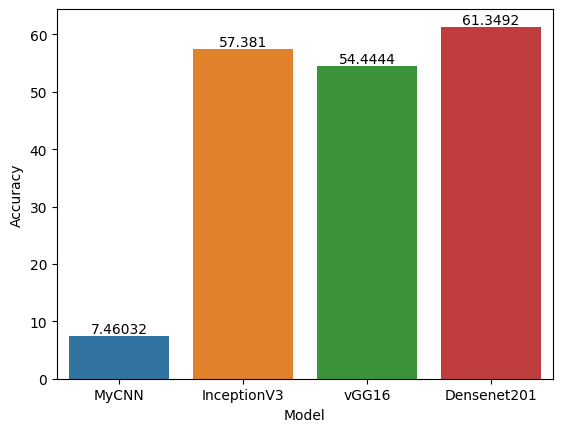

In [49]:
ax = sns.barplot(data=df_performances, x="Model", y="Accuracy")
for item in ax.containers:
    ax.bar_label(item)

### Ensemble Learning

In [50]:
combined_predictions= [model.predict(iterator) for model, iterator in \
               zip([loaded_vgg, loaded_inception, loaded_dense],\
                   [X_test_scaled, X_test_scaled, X_test_scaled])]

40/40 [==============================] - 2s 49ms/step


In [51]:
combined_predictions = np.array(combined_predictions)
#combined_predictions = np.array(combined_predictions)
predictions_sum = np.sum(combined_predictions, axis=0)

#Choosing the maximum values
predicted_from_ensemble = np.argmax(predictions_sum, axis=1)
y_test_list = list(y_test)
actual_values= [list(x).index(1) for x in y_test_list]
np.mean(predicted_from_ensemble == actual_values)

0.6373015873015873

Text(0.5, 1.0, 'Confusion Matrix for the Ensemble Model')

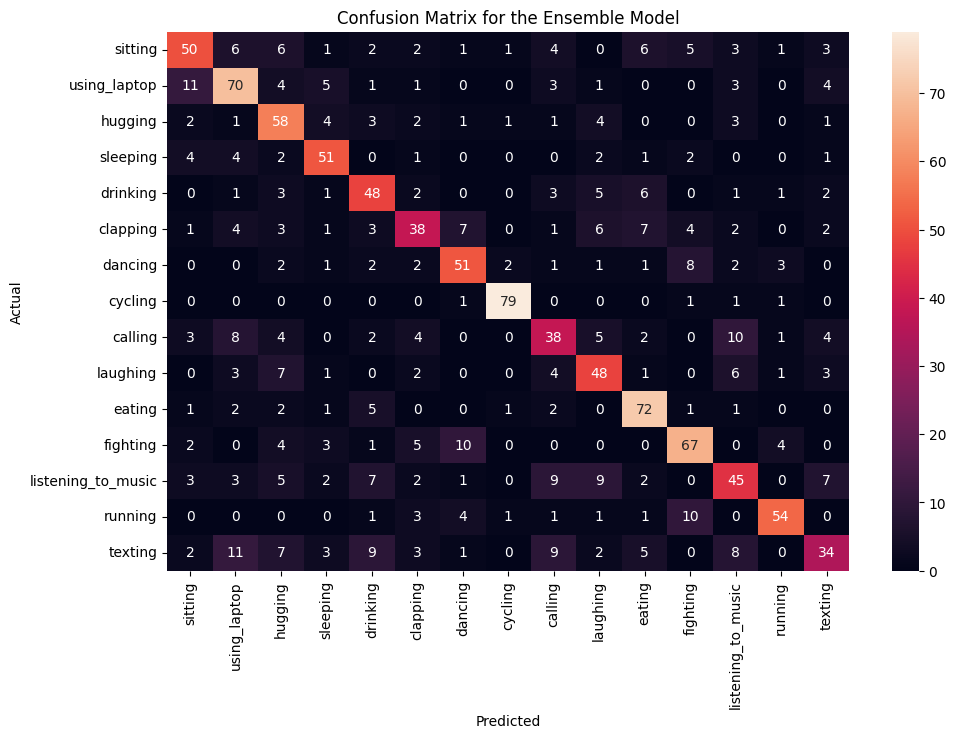

In [52]:
plot_cm(actual_values,predicted_from_ensemble,labels)
plt.title('Confusion Matrix for the Ensemble Model')

In [53]:
#Similarity between the best performing model and the ensemble model.
np.mean(predicted_from_ensemble == dense_predictions_list)

0.7682539682539683